In [1]:
import numpy as np
import pandas as pd

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

def getData(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    f_x1_x2 = benchmark(x1, x2)
    data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': f_x1_x2.flatten()}
    df = pd.DataFrame(data)
    return df


df_1000 = getData(32)
df_test = pd.read_excel("../Kriging-data.xlsx", sheet_name="Test")
df_training = pd.read_excel("../Kriging-data.xlsx", sheet_name="Training")
df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Linear")

/tmp/ipykernel_960239/2073897847.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


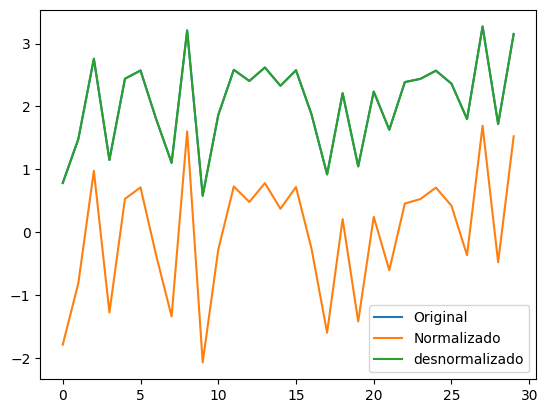

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.


remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 3.67 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-08-25 02:28:23.900539: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 02:28:24.025277: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 02:28:24.025313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 02:28:24.026618: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-25 02:28:24.046795: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 02:28:24.060832: I tensorflow/core/platform/cpu_feature_guard.cc:1

2024-08-25 02:28:25.614205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-weights.keras')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-weights.keras",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_7,0.093636,0.057344,-0.046252,0.054173,0.106952,0.559601,0.732921,0.224500,0.111266,0.327034,-0.826891,0.329580,134.470759,320.860498
model_1_0_9,0.111210,0.054671,-0.036174,0.073012,0.104878,0.561188,0.725861,0.220029,0.109207,0.323848,-0.791467,0.326369,134.509920,320.899659
model_1_0_8,0.104618,0.051641,-0.040665,0.065883,0.105656,0.562987,0.729008,0.221721,0.109516,0.325047,-0.804754,0.327577,134.495141,320.884881
model_1_0_6,0.091117,0.046311,-0.048948,0.050987,0.107249,0.566151,0.734810,0.225256,0.109880,0.327489,-0.831967,0.330037,134.465209,320.854948
model_1_0_5,0.087662,0.036907,-0.045236,0.048934,0.107656,0.571734,0.732209,0.225744,0.108140,0.328110,-0.838932,0.330664,134.457620,320.847359
model_1_0_2,0.058514,0.006758,-0.024696,0.061997,0.111096,0.589631,0.717821,0.222643,0.106141,0.333311,-0.897683,0.335904,134.394723,320.784462
model_1_0_3,0.056817,-0.005568,-0.041546,0.054201,0.111296,0.596948,0.729624,0.224494,0.103736,0.333611,-0.901103,0.336207,134.391121,320.780860
model_1_0_4,0.070009,-0.009495,-0.060800,0.051565,0.109739,0.599280,0.743112,0.225119,0.102207,0.331269,-0.874512,0.333847,134.419293,320.809032
model_1_0_1,0.019624,-0.049891,-0.073964,0.033088,0.115685,0.623261,0.752334,0.229505,0.106955,0.340125,-0.976071,0.342772,134.313769,320.703508
model_1_0_0,-0.009328,-0.063977,-0.091203,-0.001968,0.119101,0.631623,0.764410,0.237826,0.103171,0.345111,-1.034428,0.347796,134.255561,320.645300


DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_3,0.225138,0.142098,0.081999,0.045838,0.091434,0.509288,0.643078,0.164315,0.111077,0.302381,-0.561831,0.304734,134.784272,321.174011
model_1_1_4,0.256514,0.126283,0.103704,0.034327,0.087732,0.518676,0.627874,0.166297,0.107493,0.296196,-0.498590,0.298501,134.866941,321.256680
model_1_1_2,0.172867,0.119933,0.058956,0.038102,0.097602,0.522446,0.659221,0.165647,0.112317,0.312414,-0.667191,0.314845,134.653710,321.043449
model_1_1_9,0.219249,0.117582,0.219814,-0.240273,0.092129,0.523842,0.546537,0.213585,0.109738,0.303528,-0.573702,0.305890,134.769128,321.158867
model_1_1_8,0.215271,0.115846,0.210066,-0.225709,0.092598,0.524872,0.553365,0.211077,0.110406,0.304300,-0.581719,0.306668,134.758966,321.148705
model_1_1_7,0.211147,0.102136,0.188624,-0.209050,0.093085,0.533011,0.568386,0.208208,0.110744,0.305099,-0.590033,0.307473,134.748481,321.138220
model_1_1_5,0.221940,0.099158,0.159235,-0.136931,0.091812,0.534779,0.588974,0.195789,0.109567,0.303004,-0.568277,0.305362,134.776034,321.165774
model_1_1_6,0.206540,0.097089,0.174256,-0.192242,0.093629,0.536007,0.578451,0.205314,0.111123,0.305988,-0.599318,0.308369,134.736835,321.126574
model_1_1_1,0.119065,0.067548,-0.020958,0.045416,0.103951,0.553544,0.715202,0.164387,0.110447,0.322414,-0.775636,0.324923,134.527673,320.917412
model_1_1_0,0.118226,0.052809,-0.026468,0.050654,0.104050,0.562294,0.719062,0.163485,0.108140,0.322568,-0.777325,0.325078,134.525770,320.915510


DataFrame salvo em ../results/metrics_1_1


+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++

Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 207ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_0,0.221884,0.102981,0.231452,-0.333481,0.091818,0.532509,0.538384,0.058143,0.107779,0.303015,-0.568390,0.305373,134.775890,321.165629
model_1_2_1,0.224101,0.099457,0.228196,-0.380298,0.091557,0.534601,0.540665,0.060184,0.107540,0.302583,-0.563921,0.304938,134.781597,321.171336
model_1_2_2,0.212260,0.068507,0.103879,-0.892732,0.092954,0.552975,0.627751,0.082527,0.107201,0.304883,-0.587788,0.307256,134.751306,321.141045
model_1_2_3,0.193391,0.007984,-0.211460,-2.042558,0.095180,0.588904,0.848653,0.132662,0.106082,0.308513,-0.625822,0.310914,134.703963,321.093702
model_1_2_4,0.152675,0.001394,-0.429085,-2.979793,0.099985,0.592815,1.001104,0.173528,0.110385,0.316204,-0.707889,0.318665,134.605473,320.995213
model_1_2_5,0.259805,-0.259420,-1.296778,-2.235646,0.087343,0.747646,1.608941,0.141081,0.104785,0.295539,-0.491955,0.297839,134.875815,321.265554
model_1_2_6,0.140416,-0.678207,-2.099042,-4.567325,0.101431,0.996256,2.170943,0.242748,0.106816,0.318483,-0.732599,0.320961,134.576745,320.966484
model_1_2_7,0.130784,-0.734141,-2.221246,-4.749137,0.102568,1.029461,2.256550,0.250675,0.106734,0.320262,-0.752013,0.322755,134.554459,320.944198
model_1_2_8,0.239196,-1.292863,-3.566393,-3.367725,0.089775,1.361143,3.198853,0.190443,0.106806,0.299625,-0.533496,0.301957,134.820890,321.210629
model_1_2_9,0.053109,-1.587270,-4.097662,-6.268202,0.111734,1.535915,3.571018,0.316910,0.106725,0.334266,-0.908577,0.336867,134.383274,320.773013


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_1,0.194654,-1.002471,-4.500053,0.380036,0.095031,1.188753,3.852901,0.147000,0.105349,0.308272,-0.623276,0.310671,134.707097,321.096836
model_1_3_2,0.203146,-1.079061,-4.754831,0.376153,0.094029,1.234221,4.031379,0.147921,0.105135,0.306642,-0.606160,0.309028,134.728297,321.118037
model_1_3_3,0.200043,-1.173590,-4.996372,0.367821,0.094395,1.290337,4.200583,0.149896,0.105728,0.307238,-0.612414,0.309629,134.720525,321.110265
model_1_3_4,0.218844,-1.638003,-6.597208,0.297457,0.092177,1.566033,5.322002,0.166580,0.107956,0.303606,-0.574517,0.305969,134.768093,321.157832
model_1_3_5,0.226164,-1.833560,-7.052573,0.285877,0.091313,1.682124,5.640995,0.169326,0.108226,0.302181,-0.559763,0.304532,134.786922,321.176661
model_1_3_0,-0.062258,-1.837475,-4.684010,0.434460,0.125347,1.684448,3.981767,0.134095,0.106024,0.354044,-1.141115,0.356799,134.153337,320.543076
model_1_3_6,0.265685,-2.317726,-8.465037,0.247335,0.086650,1.969546,6.630455,0.178464,0.107674,0.294363,-0.480103,0.296654,134.891766,321.281506
model_1_3_8,0.289671,-2.433217,-8.596806,0.224420,0.083819,2.038106,6.722762,0.183898,0.107361,0.289516,-0.431757,0.291769,134.958185,321.347924
model_1_3_7,0.270442,-2.452129,-8.863546,0.244729,0.086088,2.049333,6.909619,0.179082,0.107422,0.293408,-0.470515,0.295691,134.904765,321.294504
model_1_3_9,0.311411,-2.818045,-9.482648,0.211139,0.081254,2.266557,7.343312,0.187047,0.105697,0.285051,-0.387938,0.287269,135.020351,321.410091


DataFrame salvo em ../results/metrics_1_3


+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_0,0.347936,-2.990557,-9.995554,0.305609,0.076944,2.368967,7.702614,0.104727,0.103706,0.277388,-0.314316,0.279546,135.129357,321.519097
model_1_4_1,0.365049,-3.089700,-10.343533,0.359844,0.074925,2.427822,7.946381,0.096547,0.102812,0.273724,-0.279823,0.275854,135.182546,321.572285
model_1_4_2,0.374390,-3.174722,-10.681499,0.379848,0.073822,2.478295,8.183133,0.093530,0.102112,0.271703,-0.260995,0.273817,135.212188,321.601927
model_1_4_3,0.382565,-3.651333,-12.174587,0.393282,0.072858,2.761232,9.229072,0.091504,0.101525,0.269922,-0.244518,0.272022,135.238494,321.628233
model_1_4_4,0.379279,-3.895671,-13.162332,0.371403,0.073245,2.906282,9.921008,0.094804,0.102251,0.270639,-0.251141,0.272745,135.227878,321.617618
model_1_4_6,0.417885,-4.182892,-14.470731,0.338721,0.068690,3.076789,10.837568,0.099733,0.099347,0.262088,-0.173326,0.264127,135.356304,321.746043
model_1_4_5,0.399085,-4.253263,-14.216077,0.359944,0.070908,3.118564,10.659178,0.096532,0.101175,0.266286,-0.211220,0.268359,135.292734,321.682473
model_1_4_7,0.424506,-4.619291,-16.376971,0.299100,0.067909,3.335854,12.172929,0.105708,0.098648,0.260593,-0.159980,0.262621,135.379183,321.768923
model_1_4_8,0.397710,-4.994758,-18.417266,0.114453,0.071071,3.558747,13.602198,0.133556,0.100389,0.266591,-0.213991,0.268665,135.288163,321.677902
model_1_4_9,0.378426,-6.397776,-24.358781,-0.001426,0.073346,4.391639,17.764353,0.151033,0.101072,0.270825,-0.252859,0.272932,135.225133,321.614872


DataFrame salvo em ../results/metrics_1_4


+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_0,0.361747,-6.577674,-24.651770,0.584409,0.075314,4.498435,17.969597,0.080965,0.100283,0.274434,-0.286478,0.276570,135.172173,321.561912
model_1_5_1,0.403758,-7.404948,-27.112511,0.557769,0.070357,4.989540,19.693398,0.086155,0.097722,0.265249,-0.201800,0.267313,135.308348,321.698087
model_1_5_2,0.409472,-8.538782,-30.968989,0.563734,0.069683,5.662633,22.394940,0.084993,0.096814,0.263975,-0.190284,0.266029,135.327606,321.717346
model_1_5_3,0.416626,-9.687228,-33.792647,0.506980,0.068839,6.344401,24.372972,0.096050,0.097364,0.262371,-0.175864,0.264413,135.351983,321.741723
model_1_5_4,0.376059,-11.069886,-36.717554,0.356060,0.073625,7.165206,26.421930,0.125452,0.100125,0.271340,-0.257632,0.273452,135.217529,321.607268
model_1_5_5,0.390692,-13.683749,-46.684055,0.354550,0.071899,8.716908,33.403671,0.125746,0.098901,0.268139,-0.228136,0.270226,135.264994,321.654733
model_1_5_6,0.309573,-16.112352,-58.291185,-0.017019,0.081471,10.158631,41.534706,0.198135,0.100550,0.285431,-0.391641,0.287652,135.015022,321.404761
model_1_5_7,0.288305,-17.155945,-62.519465,-0.119835,0.083980,10.778153,44.496705,0.218166,0.100713,0.289794,-0.434509,0.292049,134.954344,321.344083
model_1_5_8,0.304659,-18.324295,-67.443382,-0.101291,0.082051,11.471737,47.946010,0.214553,0.102434,0.286445,-0.401548,0.288674,135.000836,321.390575
model_1_5_9,0.269554,-22.242207,-86.474426,-0.316312,0.086193,13.797578,61.277652,0.256443,0.102468,0.293587,-0.472305,0.295871,134.902331,321.292071


DataFrame salvo em ../results/metrics_1_5


+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 8ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 46ms/step


 1/32 [..............................] - ETA: 1s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  22
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_8,0.100037,-20.232618,-90.334147,-0.930302,0.106196,12.604599,63.981466,0.371938,0.093936,0.325878,-0.813989,0.328414,134.484933,320.874673
model_1_6_9,-0.073649,-20.938124,-94.179557,-1.522825,0.126691,13.023418,66.675256,0.486107,0.095904,0.355937,-1.164074,0.358707,134.132005,320.521744
model_1_6_5,0.039870,-21.776126,-86.402436,-0.750754,0.113296,13.520892,61.227222,0.337342,0.105327,0.336595,-0.935263,0.339214,134.355503,320.745243
model_1_6_4,0.022566,-21.834944,-86.390966,-0.793144,0.115338,13.555809,61.219186,0.345510,0.105785,0.339614,-0.970139,0.342257,134.319781,320.709520
model_1_6_0,0.188580,-22.919581,-86.687681,-0.003074,0.095748,14.199696,61.427042,0.193276,0.105663,0.309432,-0.635518,0.311840,134.692071,321.081810
model_1_6_6,0.129423,-24.135741,-102.464767,-0.571879,0.102729,14.921661,72.479218,0.302875,0.101310,0.320513,-0.754756,0.323007,134.551330,320.941069
model_1_6_2,-0.243569,-25.745489,-89.959261,-1.510547,0.146742,15.877278,63.718851,0.483741,0.111545,0.383069,-1.506569,0.386050,133.838160,320.227899
model_1_6_3,-0.232452,-25.788537,-89.911253,-1.489609,0.145430,15.902833,63.685221,0.479707,0.111273,0.381353,-1.484161,0.384321,133.856119,320.245859
model_1_6_7,0.283440,-25.881563,-118.205850,-0.177072,0.084555,15.958057,83.506174,0.226803,0.098456,0.290783,-0.444316,0.293046,134.940718,321.330457
model_1_6_1,0.120249,-26.836047,-93.351090,-0.339691,0.103811,16.524680,66.094898,0.258137,0.105003,0.322197,-0.773248,0.324705,134.530364,320.920103


DataFrame salvo em ../results/metrics_1_6


+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_2,0.298992,-1.205435,-4.908808,0.455022,0.082719,1.309242,4.139243,0.076034,0.108829,0.287610,-0.412969,0.289848,134.984603,321.374342
model_1_7_3,0.340344,-3.582501,-11.573070,0.420063,0.077840,2.720370,8.807697,0.080911,0.111229,0.278998,-0.329620,0.281169,135.106204,321.495943
model_1_7_4,0.340543,-4.067668,-11.790832,0.397297,0.077816,3.008387,8.960244,0.084088,0.110871,0.278956,-0.329219,0.281127,135.106807,321.496546
model_1_7_5,0.372280,-5.451163,-15.340720,0.251140,0.074071,3.829689,11.447014,0.104479,0.105874,0.272160,-0.265248,0.274279,135.205453,321.595193
model_1_7_6,0.340642,-5.609319,-15.909308,0.109603,0.077805,3.923577,11.845322,0.124226,0.107334,0.278935,-0.329018,0.281106,135.107108,321.496848
model_1_7_7,0.381741,-7.031906,-19.969389,0.144163,0.072955,4.768087,14.689492,0.119404,0.102051,0.270102,-0.246178,0.272204,135.235827,321.625567
model_1_7_8,0.442987,-10.254754,-27.250704,0.144220,0.065728,6.681308,19.790205,0.119396,0.094060,0.256374,-0.122729,0.258370,135.444466,321.834205
model_1_7_1,0.167890,-11.384481,-52.978897,0.100338,0.098189,7.351963,37.813338,0.125519,0.091019,0.313352,-0.677221,0.315791,134.641713,321.031452
model_1_7_0,0.207140,-11.414877,-52.750154,0.288264,0.093558,7.370008,37.653099,0.099300,0.087304,0.305872,-0.598107,0.308253,134.738350,321.128089
model_1_7_9,0.453906,-13.715915,-36.317567,-0.004386,0.064439,8.736003,26.141731,0.140129,0.088378,0.253849,-0.100721,0.255825,135.484058,321.873798


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_1,0.528859,-13.730712,-36.311269,0.508832,0.055595,8.744787,26.137319,0.051847,0.083229,0.235786,0.050356,0.237621,135.779325,322.169064
model_1_8_0,0.524106,-13.953838,-37.028102,0.513071,0.056156,8.877244,26.639475,0.051399,0.083485,0.236972,0.040777,0.238816,135.759253,322.148993
model_1_8_2,0.531200,-13.986500,-37.659704,0.497573,0.055319,8.896634,27.081926,0.053035,0.083303,0.235199,0.055075,0.237030,135.789289,322.179029
model_1_8_3,0.537274,-14.366151,-38.673388,0.496177,0.054602,9.122011,27.792032,0.053182,0.082809,0.233671,0.067318,0.235489,135.815371,322.205110
model_1_8_5,0.559218,-14.964754,-41.771923,0.504241,0.052013,9.477368,29.962620,0.052331,0.080534,0.228063,0.111549,0.229837,135.912541,322.302280
model_1_8_4,0.548418,-15.207142,-41.557569,0.500235,0.053287,9.621259,29.812461,0.052754,0.081738,0.230840,0.089780,0.232636,135.864128,322.253867
model_1_8_6,0.563741,-21.211958,-60.199168,0.462037,0.051479,13.185978,42.871288,0.056786,0.080730,0.226890,0.120665,0.228655,135.933168,322.322907
model_1_8_8,0.570267,-21.962758,-62.735393,0.446659,0.050709,13.631685,44.647966,0.058409,0.080330,0.225186,0.133819,0.226939,135.963312,322.353051
model_1_8_7,0.566895,-21.979615,-62.429040,0.456027,0.051107,13.641692,44.433360,0.057420,0.080539,0.226068,0.127023,0.227827,135.947682,322.337421
model_1_8_9,0.575006,-22.024006,-62.989343,0.447664,0.050150,13.668044,44.825863,0.058303,0.079915,0.223941,0.143371,0.225684,135.985490,322.375229


DataFrame salvo em ../results/metrics_1_8


+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_7,0.474707,-23.968561,-71.650131,-4.412610,0.061985,14.822416,50.892926,0.159676,0.072996,0.248968,-0.058794,0.250905,135.561729,321.951468
model_1_9_8,0.208604,-24.527251,-76.573201,-10.004253,0.093385,15.154079,54.341638,0.324634,0.075786,0.305590,-0.595158,0.307968,134.742044,321.131784
model_1_9_0,0.600593,-24.631787,-71.034146,0.037332,0.047130,15.216136,50.461415,0.028399,0.077417,0.217095,0.194945,0.218785,136.109679,322.499418
model_1_9_9,0.115289,-24.859799,-78.965872,-11.952033,0.104396,15.351494,56.017754,0.382095,0.076515,0.323104,-0.783246,0.325619,134.519120,320.908859
model_1_9_2,0.558645,-25.466318,-73.026465,-1.264915,0.052080,15.711550,51.857076,0.066817,0.077532,0.228211,0.110393,0.229987,135.909941,322.299680
model_1_9_6,0.558476,-25.626997,-71.109832,-2.376465,0.052100,15.806936,50.514435,0.099608,0.073601,0.228254,0.110054,0.230031,135.909178,322.298917
model_1_9_1,0.606186,-25.911582,-73.336221,0.070275,0.046470,15.975878,52.074067,0.027428,0.076913,0.215570,0.206219,0.217247,136.137886,322.527625
model_1_9_5,0.563752,-27.201583,-73.816143,-2.230617,0.051478,16.741678,52.410262,0.095306,0.073546,0.226887,0.120687,0.228652,135.933219,322.322958
model_1_9_3,-0.635261,-30.786457,-77.605414,-25.583231,0.192962,18.869814,55.064725,0.784225,0.090749,0.439274,-2.296072,0.442693,133.290527,319.680266
model_1_9_4,-0.134570,-31.727642,-76.835031,-15.750881,0.133880,19.428542,54.525056,0.494164,0.086601,0.365896,-1.286867,0.368744,134.021624,320.411363


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  25
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++

Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_1,-0.840206,-9.168742,-20.130905,-9.484455,0.217145,6.036604,14.802638,0.814505,0.106034,0.465989,-2.709165,0.469615,133.054376,319.444115
model_1_10_0,0.176803,-21.285316,-65.582841,0.260077,0.097138,13.229526,46.642663,0.057482,0.076492,0.311669,-0.659256,0.314095,134.663251,321.052990


DataFrame salvo em ../results/metrics_1_10


+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 1 ++++++++++++++++++

Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_3,-0.285967,-0.106443,-0.008178,0.224928,0.151745,0.656832,0.706250,0.161726,0.117841,0.389544,-1.592027,0.392576,133.771109,320.160848
model_1_12_4,-0.281402,-0.150091,-0.292757,0.093531,0.151206,0.682744,0.905603,0.189143,0.120583,0.388852,-1.582826,0.391879,133.778221,320.167961
model_1_12_2,-0.418800,-0.156168,0.045565,0.328140,0.167419,0.686351,0.668601,0.140190,0.119087,0.409169,-1.859769,0.412353,133.574508,319.964247
model_1_12_5,-0.217248,-0.192136,-0.425064,-0.095138,0.143636,0.707703,0.998287,0.228510,0.118765,0.378993,-1.453516,0.381943,133.880945,320.270685
model_1_12_6,-0.244058,-0.212234,-0.471102,-0.173093,0.146800,0.719635,1.030537,0.244776,0.119609,0.383144,-1.507554,0.386126,133.837374,320.227113
model_1_12_7,-0.221367,-0.263215,-0.587441,-0.373803,0.144122,0.749899,1.112036,0.286656,0.119210,0.379634,-1.461818,0.382588,133.874190,320.263929
model_1_12_1,-0.641185,-0.266493,-0.150519,0.209539,0.193661,0.751845,0.805962,0.164937,0.125270,0.440069,-2.308014,0.443494,133.283294,319.673033
model_1_12_8,-0.225867,-0.325794,-0.725528,-0.600224,0.144653,0.787048,1.208768,0.333901,0.118065,0.380333,-1.470888,0.383293,133.866834,320.256573
model_1_12_9,-0.476085,-0.563433,-1.113765,-1.487645,0.174179,0.928121,1.480736,0.519069,0.123263,0.417348,-1.975234,0.420595,133.495344,319.885083
model_1_12_0,-1.787113,-0.569268,-1.008907,0.201127,0.328881,0.931586,1.407281,0.166692,0.132574,0.573481,-4.617774,0.577944,132.224119,318.613858


DataFrame salvo em ../results/metrics_1_12


+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_3,0.127553,-0.473516,-1.135651,-0.233284,0.102949,0.874743,1.496068,0.127711,0.105016,0.320857,-0.758527,0.323354,134.547037,320.936776
model_1_13_1,-0.270649,-0.535666,-1.535396,-0.516226,0.149937,0.911638,1.776098,0.157010,0.125039,0.387217,-1.561152,0.390231,133.795075,320.184815
model_1_13_4,0.249717,-0.581039,-1.051259,-0.345911,0.088534,0.938573,1.436949,0.139374,0.102232,0.297546,-0.512289,0.299862,134.848741,321.238480
model_1_13_2,-0.258203,-0.582081,-1.661034,-0.547439,0.148469,0.939192,1.864109,0.160242,0.124298,0.385316,-1.536065,0.388315,133.814763,320.204502
model_1_13_0,-0.448285,-0.626379,-1.246615,-0.379842,0.170899,0.965489,1.573801,0.142887,0.122808,0.413399,-1.919200,0.416616,133.533371,319.923110
model_1_13_5,0.288177,-0.713077,-1.926830,-0.456306,0.083996,1.016956,2.050305,0.150805,0.100954,0.289820,-0.434768,0.292075,134.953984,321.343723
model_1_13_9,-0.982956,-2.150985,-1.821142,-8.275032,0.233990,1.870561,1.976269,0.960460,0.118986,0.483725,-2.996896,0.487490,132.904953,319.294693
model_1_13_7,-0.966011,-2.584484,-1.836535,-8.098562,0.231990,2.127905,1.987052,0.942186,0.113733,0.481654,-2.962740,0.485402,132.922118,319.311857
model_1_13_8,-1.007569,-2.618128,-1.813679,-8.366481,0.236894,2.147877,1.971040,0.969930,0.113725,0.486718,-3.046507,0.490506,132.880282,319.270021
model_1_13_6,-1.484911,-2.793955,-1.953968,-10.994221,0.293221,2.252255,2.069316,1.242041,0.123561,0.541499,-4.008649,0.545713,132.453657,318.843397


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  27
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  25
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++


Stopped at epoch:  24
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  22
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  0
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_6,0.088981,0.076970,-0.001105,-1.341289,0.107501,0.547950,0.701295,0.096399,0.144886,0.327873,-0.836273,0.330425,134.460514,320.850253
model_1_17_5,0.020113,0.019055,-0.042759,-1.013972,0.115627,0.582331,0.730474,0.082922,0.151213,0.340040,-0.975085,0.342686,134.314766,320.704506
model_1_17_4,0.011069,0.011197,-0.040024,-1.020482,0.116694,0.586996,0.728558,0.083190,0.151949,0.341606,-0.993314,0.344264,134.296392,320.686132
model_1_17_3,-0.001468,0.004929,-0.040982,-1.036419,0.118174,0.590717,0.729230,0.083847,0.152997,0.343764,-1.018583,0.346439,134.271198,320.660937
model_1_17_2,-0.028411,-0.029816,-0.061716,-1.029531,0.121353,0.611344,0.743754,0.083563,0.155131,0.348358,-1.072891,0.351069,134.218101,320.607840
model_1_17_1,-0.034503,-0.035690,-0.064021,-1.082291,0.122072,0.614830,0.745369,0.085735,0.156214,0.349388,-1.085169,0.352107,134.206290,320.596029
model_1_17_0,-0.054521,-0.037025,-0.079624,-1.127045,0.124434,0.615623,0.756299,0.087578,0.158023,0.352752,-1.125520,0.355497,134.167957,320.557696


DataFrame salvo em ../results/metrics_1_17


+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 10ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  23
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_7,0.287690,0.110774,0.000985,-2.206034,0.084053,0.527883,0.699831,0.074118,0.121488,0.289919,-0.435749,0.292175,134.952616,321.342355
model_1_18_8,0.298428,0.109479,0.002913,-2.299153,0.082786,0.528652,0.698480,0.076271,0.119968,0.287725,-0.414106,0.289965,134.982994,321.372733
model_1_18_6,0.275850,0.108061,0.001128,-2.196195,0.085450,0.529494,0.699730,0.073891,0.123109,0.292319,-0.459615,0.294593,134.919644,321.309383
model_1_18_3,0.251163,0.105159,-0.000247,-1.683578,0.088363,0.531216,0.700694,0.062040,0.127715,0.297260,-0.509375,0.299573,134.852598,321.242337
model_1_18_5,0.266585,0.104801,0.000234,-1.910463,0.086543,0.531429,0.700357,0.067285,0.125120,0.294183,-0.478290,0.296472,134.894217,321.283957
model_1_18_4,0.257839,0.103327,0.000049,-1.732231,0.087575,0.532304,0.700486,0.063165,0.126766,0.295931,-0.495918,0.298234,134.870509,321.260248
model_1_18_2,0.243995,0.103258,-0.000427,-1.619752,0.089209,0.532345,0.700820,0.060564,0.128830,0.298679,-0.523823,0.301003,134.833544,321.223284
model_1_18_1,0.162279,0.089435,-0.003920,-1.701156,0.098852,0.540551,0.703267,0.062446,0.137776,0.314407,-0.688532,0.316854,134.628271,321.018010
model_1_18_0,0.151857,0.088094,-0.004655,-1.705813,0.100081,0.541347,0.703782,0.062554,0.138737,0.316356,-0.709539,0.318818,134.603543,320.993282
model_1_18_9,0.358476,0.062489,0.035563,-3.391517,0.075700,0.556547,0.675608,0.101525,0.108169,0.275137,-0.293072,0.277278,135.161949,321.551688


DataFrame salvo em ../results/metrics_1_18


+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  24
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_0,0.366617,0.064412,0.038927,0.658239,0.074740,0.555405,0.673251,0.068710,0.106894,0.273385,-0.276663,0.275513,135.187491,321.577230
model_1_19_1,0.367278,0.054785,0.075649,0.400071,0.074662,0.561120,0.647527,0.120614,0.100204,0.273243,-0.275330,0.275369,135.189580,321.579320
model_1_19_2,0.357485,0.043589,0.082191,0.253205,0.075817,0.567767,0.642944,0.150141,0.097681,0.275349,-0.295070,0.277492,135.158861,321.548600
model_1_19_3,0.358203,0.040237,0.082879,0.229261,0.075732,0.569757,0.642462,0.154955,0.096796,0.275195,-0.293621,0.277337,135.161099,321.550838
model_1_19_4,0.361124,0.039438,0.084627,0.224581,0.075388,0.570231,0.641238,0.155896,0.096211,0.274568,-0.287734,0.276705,135.170222,321.559961
model_1_19_5,0.349474,0.034500,0.085761,0.118242,0.076762,0.573162,0.640443,0.177275,0.094477,0.277060,-0.311217,0.279217,135.134079,321.523818
model_1_19_6,0.342092,0.033432,0.100942,0.060582,0.077634,0.573797,0.629809,0.188867,0.091848,0.278628,-0.326097,0.280796,135.111510,321.501249
model_1_19_7,0.325945,0.027510,0.111673,-0.024278,0.079539,0.577312,0.622291,0.205928,0.091421,0.282027,-0.358643,0.284221,135.063017,321.452756
model_1_19_8,0.270847,-0.004698,0.102971,-0.223138,0.086040,0.596432,0.628388,0.245908,0.092266,0.293327,-0.469699,0.295609,134.905875,321.295614
model_1_19_9,0.165357,-0.040000,0.075549,-0.550363,0.098488,0.617389,0.647597,0.311696,0.092796,0.313829,-0.682327,0.316271,134.635634,321.025373


DataFrame salvo em ../results/metrics_1_19


+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_4,0.383400,0.001700,0.229219,-0.124790,0.072759,0.592634,0.539948,0.138483,0.079494,0.269739,-0.242835,0.271838,135.241200,321.630939
model_1_20_5,0.462286,0.001155,0.222336,0.187941,0.063451,0.592958,0.544770,0.099980,0.074582,0.251894,-0.083829,0.253854,135.514989,321.904728
model_1_20_6,0.453687,-0.009192,0.212495,0.009415,0.064465,0.599100,0.551664,0.121960,0.075686,0.253900,-0.101162,0.255876,135.483258,321.872997
model_1_20_7,0.442504,-0.024794,0.230350,-0.078187,0.065785,0.608362,0.539156,0.132745,0.075897,0.256486,-0.123704,0.258482,135.442730,321.832469
model_1_20_3,0.146341,-0.028282,0.038900,-1.188863,0.100732,0.610433,0.673270,0.269491,0.089316,0.317384,-0.720657,0.319854,134.590577,320.980316
model_1_20_1,0.083374,-0.038917,0.082781,-1.277362,0.108162,0.616746,0.642531,0.280386,0.093343,0.328881,-0.847575,0.331440,134.448242,320.837981
model_1_20_2,0.155550,-0.040418,0.098131,-1.070952,0.099646,0.617637,0.631778,0.254974,0.089133,0.315667,-0.702095,0.318124,134.612270,321.002010
model_1_20_8,0.429481,-0.049654,0.125977,-0.180139,0.067322,0.623120,0.612271,0.145298,0.077303,0.259464,-0.149952,0.261483,135.396550,321.786289
model_1_20_0,0.126962,-0.053147,0.137892,-0.891813,0.103019,0.625194,0.603924,0.232918,0.092119,0.320966,-0.759716,0.323464,134.545684,320.935424
model_1_20_9,0.401302,-0.070375,0.132736,-0.350915,0.070647,0.635421,0.607536,0.166323,0.078593,0.265795,-0.206751,0.267863,135.300126,321.689866


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_1,-0.132360,-0.091838,0.083074,-2.531493,0.133619,0.648162,0.642326,0.351529,0.098291,0.365540,-1.282414,0.368384,134.025522,320.415262
model_1_21_0,0.366653,-0.098613,0.139268,0.756120,0.074735,0.652184,0.602960,0.024276,0.080462,0.273378,-0.276590,0.275505,135.187605,321.577344
model_1_21_2,-0.356150,-0.218572,-0.131244,-4.144985,0.160026,0.723397,0.792460,0.512137,0.116819,0.400033,-1.733489,0.403146,133.664832,320.054571
model_1_21_3,-0.387168,-0.318252,-0.129208,-4.406108,0.163687,0.782571,0.791033,0.538130,0.117500,0.404582,-1.796011,0.407731,133.619602,320.009341
model_1_21_6,-0.951381,-0.488744,-0.244941,-7.949878,0.230264,0.883783,0.872107,0.890881,0.125370,0.479858,-2.933252,0.483593,132.937056,319.326796
model_1_21_5,-0.821493,-0.499184,-0.229473,-7.090940,0.214937,0.889981,0.861271,0.805381,0.124103,0.463613,-2.671448,0.467221,133.074818,319.464557
model_1_21_4,-0.767565,-0.506730,-0.164152,-6.758735,0.208574,0.894460,0.815512,0.772313,0.123160,0.456699,-2.562748,0.460253,133.134925,319.524665
model_1_21_7,-1.330780,-0.680463,0.091051,-10.262040,0.275033,0.997595,0.636738,1.121036,0.128966,0.524436,-3.697978,0.528518,132.581725,318.971465
model_1_21_9,-1.368839,-0.691427,0.001517,-10.914564,0.279524,1.004104,0.699458,1.185989,0.117993,0.528701,-3.774691,0.532815,132.549331,318.939070
model_1_21_8,-1.212668,-0.748929,0.016874,-9.646640,0.261096,1.038240,0.688700,1.059778,0.123009,0.510976,-3.459909,0.514952,132.685733,319.075472


DataFrame salvo em ../results/metrics_1_21


+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_5,-0.045487,-0.127195,-0.250150,0.099765,0.123368,0.669152,0.875756,0.075395,0.120675,0.351238,-1.107310,0.353971,134.185165,320.574904
model_1_22_4,-0.046788,-0.128583,-0.252459,0.100113,0.123522,0.669976,0.877373,0.075365,0.120953,0.351456,-1.109932,0.354192,134.182678,320.572418
model_1_22_3,-0.048120,-0.129476,-0.254796,0.100430,0.123679,0.670506,0.879011,0.075339,0.121234,0.351680,-1.112618,0.354417,134.180134,320.569873
model_1_22_2,-0.049488,-0.130864,-0.257163,0.100698,0.123840,0.671330,0.880669,0.075316,0.121523,0.351909,-1.115374,0.354648,134.177526,320.567266
model_1_22_6,-0.043517,-0.138440,-0.234638,0.051454,0.123136,0.675827,0.864889,0.079441,0.119080,0.350907,-1.103338,0.353638,134.188938,320.578677
model_1_22_7,-0.042410,-0.141949,-0.232549,0.051166,0.123005,0.677910,0.863426,0.079465,0.118835,0.350721,-1.101107,0.353450,134.191061,320.580800
model_1_22_8,-0.611711,-0.204663,-0.230485,-3.967412,0.190183,0.715140,0.861980,0.416020,0.129327,0.436100,-2.248605,0.439493,133.319538,319.709278
model_1_22_9,-0.035537,-0.208648,-0.647165,0.091305,0.122194,0.717506,1.153873,0.076103,0.118272,0.349563,-1.087254,0.352283,134.204291,320.594030
model_1_22_1,-2.762933,-0.309730,-0.274980,-12.484107,0.444028,0.777512,0.893150,1.129293,0.180373,0.666355,-6.584661,0.671540,131.623734,318.013473
model_1_22_0,-1.366970,-0.690490,0.001827,0.025105,0.279304,1.003548,0.699241,0.081647,0.117889,0.528492,-3.770924,0.532605,132.550910,318.940649


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_9,-0.019018,-0.159633,-0.195235,-0.070014,0.120245,0.688408,0.837287,0.121121,0.112872,0.346763,-1.053958,0.349462,134.236452,320.626191
model_1_23_8,-0.019412,-0.159991,-0.196236,-0.070397,0.120291,0.688621,0.837988,0.121165,0.113041,0.346830,-1.054753,0.349529,134.235679,320.625418
model_1_23_7,-0.019815,-0.160355,-0.197249,-0.070791,0.120339,0.688837,0.838698,0.121209,0.113210,0.346899,-1.055564,0.349598,134.234889,320.624628
model_1_23_6,-0.020226,-0.160716,-0.198273,-0.071197,0.120387,0.689051,0.839415,0.121255,0.113382,0.346969,-1.056393,0.349669,134.234082,320.623822
model_1_23_5,-0.020647,-0.161081,-0.199309,-0.071614,0.120437,0.689268,0.840141,0.121302,0.113555,0.347040,-1.057241,0.349741,134.233258,320.622998
model_1_23_4,-0.021076,-0.161449,-0.200357,-0.072042,0.120488,0.689486,0.840875,0.121351,0.113730,0.347113,-1.058106,0.349815,134.232417,320.622156
model_1_23_3,-0.021515,-0.161820,-0.201417,-0.072483,0.120539,0.689707,0.841617,0.121401,0.113907,0.347188,-1.058991,0.349890,134.231557,320.621297
model_1_23_2,-0.021963,-0.162199,-0.202488,-0.072936,0.120592,0.689932,0.842368,0.121452,0.114085,0.347264,-1.059895,0.349966,134.230680,320.620419
model_1_23_0,-0.028738,-0.169701,-0.641211,-0.078734,0.121392,0.694385,1.149703,0.122108,0.116611,0.348413,-1.073551,0.351125,134.217465,320.607204
model_1_23_1,-0.022426,-0.189031,-0.203575,-0.073390,0.120647,0.705860,0.843129,0.121503,0.114268,0.347343,-1.060828,0.350046,134.229774,320.619514


DataFrame salvo em ../results/metrics_1_23


+++++++++++ [1_24] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_9,-0.015784,-0.155459,-0.186403,-0.107274,0.119863,0.685931,0.831100,0.068488,0.112106,0.346212,-1.047439,0.348907,134.242810,320.632549
model_1_24_8,-0.016078,-0.155855,-0.187243,-0.107767,0.119898,0.686165,0.831688,0.068518,0.112179,0.346263,-1.048033,0.348957,134.242230,320.631969
model_1_24_7,-0.016379,-0.156255,-0.188092,-0.108271,0.119933,0.686403,0.832283,0.068549,0.112253,0.346314,-1.048639,0.349009,134.241638,320.631378
model_1_24_6,-0.016686,-0.156657,-0.188950,-0.108786,0.119970,0.686641,0.832884,0.068581,0.112328,0.346366,-1.049257,0.349062,134.241035,320.630774
model_1_24_5,-0.016999,-0.157066,-0.189818,-0.109312,0.120006,0.686885,0.833492,0.068614,0.112403,0.346420,-1.049889,0.349115,134.240419,320.630158
model_1_24_4,-0.017319,-0.157478,-0.190695,-0.109850,0.120044,0.687129,0.834107,0.068647,0.112480,0.346474,-1.050533,0.349170,134.239790,320.629530
model_1_24_3,-0.017645,-0.157898,-0.191583,-0.110399,0.120083,0.687378,0.834729,0.068681,0.112557,0.346530,-1.051190,0.349226,134.239149,320.628889
model_1_24_2,-0.017978,-0.158329,-0.192481,-0.110961,0.120122,0.687634,0.835357,0.068716,0.112634,0.346586,-1.051861,0.349283,134.238495,320.628234
model_1_24_1,-0.018318,-0.158761,-0.193388,-0.111535,0.120162,0.687891,0.835993,0.068751,0.112713,0.346644,-1.052546,0.349342,134.237827,320.627567
model_1_24_0,-0.018664,-0.159193,-0.194306,-0.112122,0.120203,0.688147,0.836636,0.068788,0.112792,0.346703,-1.053245,0.349401,134.237147,320.626886


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_9,-0.012706,-0.152685,-0.177521,-0.027649,0.119500,0.684284,0.824878,0.108683,0.110615,0.345688,-1.041236,0.348378,134.248879,320.638618
model_1_25_8,-0.012984,-0.152949,-0.178366,-0.027624,0.119533,0.684440,0.825470,0.108680,0.110757,0.345735,-1.041797,0.348426,134.248329,320.638069
model_1_25_7,-0.013269,-0.153216,-0.179220,-0.027602,0.119566,0.684599,0.826068,0.108678,0.110901,0.345784,-1.042370,0.348475,134.247768,320.637507
model_1_25_6,-0.013560,-0.153495,-0.180083,-0.027582,0.119601,0.684764,0.826673,0.108676,0.111046,0.345833,-1.042956,0.348525,134.247194,320.636933
model_1_25_5,-0.013857,-0.153761,-0.180956,-0.027565,0.119636,0.684922,0.827284,0.108674,0.111193,0.345884,-1.043556,0.348576,134.246607,320.636346
model_1_25_4,-0.014161,-0.154022,-0.181839,-0.027550,0.119672,0.685077,0.827903,0.108673,0.111341,0.345936,-1.044168,0.348628,134.246008,320.635747
model_1_25_3,-0.014471,-0.154295,-0.182731,-0.027538,0.119708,0.685239,0.828528,0.108671,0.111491,0.345989,-1.044794,0.348681,134.245396,320.635135
model_1_25_2,-0.014789,-0.154589,-0.183634,-0.027529,0.119746,0.685414,0.829160,0.108670,0.111643,0.346043,-1.045434,0.348736,134.244770,320.634509
model_1_25_1,-0.015113,-0.154878,-0.184547,-0.027523,0.119784,0.685585,0.829800,0.108670,0.111795,0.346098,-1.046088,0.348792,134.244131,320.633870
model_1_25_0,-0.015445,-0.155162,-0.185470,-0.027520,0.119823,0.685754,0.830446,0.108669,0.111950,0.346155,-1.046756,0.348849,134.243477,320.633217


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_9,-0.010500,-0.149727,-0.170396,-0.027301,0.119240,0.682528,0.819887,0.126878,0.109883,0.345311,-1.036789,0.347998,134.253240,320.642979
model_1_26_8,-0.010702,-0.150006,-0.171074,-0.027549,0.119263,0.682693,0.820362,0.126909,0.109953,0.345345,-1.037196,0.348033,134.252841,320.642581
model_1_26_7,-0.010907,-0.150297,-0.171760,-0.027802,0.119288,0.682866,0.820842,0.126940,0.110023,0.345380,-1.037610,0.348068,134.252435,320.642174
model_1_26_6,-0.011117,-0.150582,-0.172452,-0.028059,0.119312,0.683035,0.821327,0.126972,0.110095,0.345416,-1.038032,0.348104,134.252020,320.641759
model_1_26_5,-0.011331,-0.150863,-0.173153,-0.028321,0.119338,0.683202,0.821818,0.127004,0.110167,0.345453,-1.038463,0.348141,134.251597,320.641336
model_1_26_4,-0.011549,-0.151156,-0.173861,-0.028588,0.119363,0.683376,0.822314,0.127037,0.110239,0.345490,-1.038903,0.348179,134.251166,320.640905
model_1_26_3,-0.011771,-0.151461,-0.174577,-0.028860,0.119390,0.683557,0.822816,0.127071,0.110313,0.345528,-1.039351,0.348217,134.250726,320.640466
model_1_26_2,-0.011998,-0.151753,-0.175301,-0.029138,0.119416,0.683731,0.823323,0.127105,0.110387,0.345567,-1.039808,0.348256,134.250278,320.640017
model_1_26_1,-0.012229,-0.152066,-0.176033,-0.029420,0.119444,0.683916,0.823836,0.127140,0.110462,0.345606,-1.040275,0.348296,134.249821,320.639560
model_1_26_0,-0.012465,-0.152374,-0.176773,-0.029708,0.119472,0.684099,0.824354,0.127175,0.110538,0.345647,-1.040750,0.348336,134.249354,320.639094


DataFrame salvo em ../results/metrics_1_26


+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_9,-0.008974,-0.149423,-0.164966,-0.155689,0.119060,0.682347,0.816083,0.254808,0.108191,0.345050,-1.033714,0.347735,134.256263,320.646002
model_1_27_8,-0.009101,-0.149446,-0.165482,-0.155146,0.119074,0.682361,0.816445,0.254689,0.108353,0.345072,-1.033968,0.347757,134.256012,320.645751
model_1_27_7,-0.009232,-0.149483,-0.166004,-0.154599,0.119090,0.682383,0.816810,0.254568,0.108516,0.345094,-1.034234,0.347780,134.255751,320.645490
model_1_27_6,-0.009370,-0.149512,-0.166532,-0.154050,0.119106,0.682400,0.817180,0.254447,0.108681,0.345118,-1.034511,0.347804,134.255479,320.645218
model_1_27_5,-0.009513,-0.149552,-0.167065,-0.153497,0.119123,0.682424,0.817554,0.254325,0.108848,0.345142,-1.034800,0.347828,134.255195,320.644934
model_1_27_4,-0.009662,-0.149576,-0.167605,-0.152941,0.119141,0.682438,0.817931,0.254203,0.109016,0.345168,-1.035100,0.347854,134.254900,320.644639
model_1_27_3,-0.009817,-0.149615,-0.168150,-0.152381,0.119159,0.682461,0.818314,0.254079,0.109186,0.345194,-1.035412,0.347881,134.254593,320.644332
model_1_27_2,-0.009978,-0.149642,-0.168702,-0.151818,0.119178,0.682477,0.818700,0.253955,0.109357,0.345222,-1.035737,0.347908,134.254274,320.644013
model_1_27_1,-0.010146,-0.149665,-0.169261,-0.151252,0.119198,0.682491,0.819092,0.253830,0.109531,0.345250,-1.036075,0.347937,134.253942,320.643681
model_1_27_0,-0.010320,-0.149697,-0.169826,-0.150683,0.119218,0.682510,0.819487,0.253705,0.109706,0.345280,-1.036426,0.347967,134.253598,320.643337


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_9,-0.006761,-0.145559,-0.156751,-0.128865,0.118798,0.680053,0.810328,0.049253,0.107606,0.344671,-1.029252,0.347354,134.260655,320.650394
model_1_28_8,-0.006957,-0.145925,-0.157531,-0.128308,0.118822,0.680271,0.810875,0.049229,0.107662,0.344705,-1.029648,0.347388,134.260265,320.650004
model_1_28_7,-0.007159,-0.146295,-0.158321,-0.127756,0.118845,0.680491,0.811428,0.049205,0.107719,0.344740,-1.030055,0.347422,134.259864,320.649604
model_1_28_6,-0.007366,-0.146673,-0.159119,-0.127209,0.118870,0.680715,0.811987,0.049181,0.107776,0.344775,-1.030472,0.347458,134.259453,320.649193
model_1_28_5,-0.007578,-0.147051,-0.159926,-0.126668,0.118895,0.680939,0.812552,0.049158,0.107833,0.344811,-1.030900,0.347495,134.259032,320.648771
model_1_28_4,-0.007796,-0.147435,-0.160743,-0.126133,0.118921,0.681167,0.813124,0.049134,0.107892,0.344849,-1.031339,0.347532,134.258599,320.648338
model_1_28_3,-0.008020,-0.147822,-0.161568,-0.125605,0.118947,0.681397,0.813703,0.049111,0.107950,0.344887,-1.031790,0.347571,134.258155,320.647895
model_1_28_2,-0.008249,-0.148212,-0.162404,-0.125083,0.118974,0.681628,0.814288,0.049088,0.108010,0.344926,-1.032253,0.347610,134.257700,320.647439
model_1_28_1,-0.008485,-0.148612,-0.163248,-0.124569,0.119002,0.681865,0.814879,0.049066,0.108070,0.344966,-1.032727,0.347651,134.257233,320.646972
model_1_28_0,-0.008726,-0.149016,-0.164102,-0.124061,0.119030,0.682106,0.815478,0.049044,0.108130,0.345008,-1.033214,0.347693,134.256754,320.646493


DataFrame salvo em ../results/metrics_1_28


+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++

Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_9,-0.005394,-0.142700,-0.150927,-0.252216,0.118637,0.678356,0.806248,0.030153,0.107272,0.344437,-1.026498,0.347118,134.263371,320.653111
model_1_29_8,-0.005516,-0.142973,-0.151481,-0.251852,0.118652,0.678518,0.806636,0.030144,0.107304,0.344458,-1.026744,0.347139,134.263129,320.652868
model_1_29_7,-0.005641,-0.143246,-0.152041,-0.251496,0.118666,0.678680,0.807029,0.030135,0.107337,0.344480,-1.026996,0.347161,134.262880,320.652619
model_1_29_6,-0.005769,-0.143523,-0.152607,-0.251146,0.118681,0.678845,0.807425,0.030127,0.107369,0.344502,-1.027254,0.347183,134.262625,320.652365
model_1_29_5,-0.005901,-0.143803,-0.153180,-0.250805,0.118697,0.679011,0.807826,0.030119,0.107402,0.344524,-1.027519,0.347205,134.262364,320.652103
model_1_29_4,-0.006036,-0.144087,-0.153759,-0.250473,0.118713,0.679179,0.808232,0.030111,0.107435,0.344547,-1.027790,0.347229,134.262096,320.651836
model_1_29_3,-0.006174,-0.144371,-0.154344,-0.250148,0.118729,0.679348,0.808642,0.030103,0.107469,0.344571,-1.028069,0.347252,134.261822,320.651561
model_1_29_2,-0.006315,-0.144662,-0.154936,-0.249833,0.118746,0.679521,0.809056,0.030095,0.107503,0.344595,-1.028354,0.347277,134.261541,320.651280
model_1_29_1,-0.006460,-0.144956,-0.155534,-0.249527,0.118763,0.679695,0.809476,0.030088,0.107537,0.344620,-1.028646,0.347302,134.261252,320.650992
model_1_29_0,-0.006609,-0.145256,-0.156139,-0.249230,0.118780,0.679873,0.809899,0.030081,0.107571,0.344645,-1.028946,0.347327,134.260957,320.650696


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_9,-0.004443,-0.139740,-0.145966,-0.192610,0.118525,0.676599,0.802773,0.079854,0.107269,0.344275,-1.024581,0.346954,134.265264,320.655003
model_1_30_8,-0.004524,-0.140019,-0.146438,-0.191718,0.118534,0.676765,0.803103,0.079794,0.107269,0.344288,-1.024744,0.346968,134.265103,320.654843
model_1_30_7,-0.004608,-0.140301,-0.146914,-0.190821,0.118544,0.676932,0.803437,0.079734,0.107270,0.344303,-1.024912,0.346982,134.264937,320.654676
model_1_30_6,-0.004694,-0.140570,-0.147397,-0.189919,0.118555,0.677092,0.803775,0.079673,0.107270,0.344317,-1.025087,0.346997,134.264765,320.654504
model_1_30_5,-0.004784,-0.140859,-0.147884,-0.189010,0.118565,0.677263,0.804117,0.079613,0.107270,0.344333,-1.025268,0.347013,134.264586,320.654325
model_1_30_4,-0.004877,-0.141168,-0.148377,-0.188095,0.118576,0.677447,0.804462,0.079551,0.107271,0.344349,-1.025455,0.347029,134.264401,320.654140
model_1_30_3,-0.004973,-0.141481,-0.148876,-0.187175,0.118587,0.677632,0.804811,0.079490,0.107271,0.344365,-1.025650,0.347045,134.264209,320.653948
model_1_30_2,-0.005073,-0.141780,-0.149380,-0.186248,0.118599,0.677810,0.805164,0.079428,0.107271,0.344382,-1.025851,0.347062,134.264010,320.653749
model_1_30_1,-0.005177,-0.142083,-0.149890,-0.185317,0.118611,0.677990,0.805522,0.079365,0.107272,0.344400,-1.026059,0.347080,134.263804,320.653544
model_1_30_0,-0.005284,-0.142390,-0.150405,-0.184379,0.118624,0.678172,0.805883,0.079302,0.107272,0.344418,-1.026275,0.347099,134.263591,320.653331


DataFrame salvo em ../results/metrics_1_30


+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_9,-0.002832,-0.137637,-0.137806,0.031357,0.118335,0.675350,0.797056,0.105246,0.105775,0.343998,-1.021333,0.346675,134.268475,320.658215
model_1_31_8,-0.002971,-0.137826,-0.138581,0.031965,0.118351,0.675463,0.797600,0.105180,0.105918,0.344022,-1.021612,0.346699,134.268199,320.657938
model_1_31_7,-0.003114,-0.138018,-0.139366,0.032575,0.118368,0.675577,0.798149,0.105113,0.106062,0.344047,-1.021902,0.346724,134.267913,320.657652
model_1_31_6,-0.003262,-0.138230,-0.140159,0.033187,0.118386,0.675702,0.798705,0.105047,0.106208,0.344072,-1.022200,0.346750,134.267617,320.657357
model_1_31_5,-0.003415,-0.138419,-0.140961,0.033802,0.118404,0.675815,0.799267,0.104980,0.106355,0.344098,-1.022509,0.346776,134.267312,320.657051
model_1_31_4,-0.003573,-0.138612,-0.141772,0.034418,0.118422,0.675929,0.799835,0.104913,0.106503,0.344125,-1.022828,0.346803,134.266997,320.656736
model_1_31_3,-0.003737,-0.138845,-0.142592,0.035037,0.118442,0.676068,0.800410,0.104846,0.106653,0.344153,-1.023157,0.346832,134.266672,320.656411
model_1_31_2,-0.003905,-0.139070,-0.143422,0.035658,0.118461,0.676201,0.800991,0.104779,0.106805,0.344182,-1.023496,0.346861,134.266336,320.656075
model_1_31_1,-0.004079,-0.139293,-0.144260,0.036280,0.118482,0.676333,0.801578,0.104711,0.106958,0.344212,-1.023847,0.346891,134.265990,320.655729
model_1_31_0,-0.004258,-0.139528,-0.145109,0.036905,0.118503,0.676473,0.802172,0.104643,0.107113,0.344243,-1.024208,0.346922,134.265632,320.655372


DataFrame salvo em ../results/metrics_1_31


+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_9,-0.001873,-0.134795,-0.131438,-0.054748,0.118222,0.673663,0.792596,0.041239,0.105148,0.343834,-1.019400,0.346509,134.270389,320.660128
model_1_32_8,-0.001956,-0.135065,-0.132044,-0.053691,0.118231,0.673824,0.793020,0.041198,0.105208,0.343848,-1.019568,0.346524,134.270223,320.659962
model_1_32_7,-0.002042,-0.135338,-0.132656,-0.052626,0.118242,0.673986,0.793449,0.041156,0.105268,0.343863,-1.019740,0.346539,134.270052,320.659791
model_1_32_6,-0.002130,-0.135612,-0.133275,-0.051556,0.118252,0.674149,0.793883,0.041114,0.105330,0.343878,-1.019919,0.346554,134.269875,320.659614
model_1_32_5,-0.002222,-0.135892,-0.133901,-0.050477,0.118263,0.674314,0.794321,0.041072,0.105391,0.343894,-1.020103,0.346570,134.269693,320.659432
model_1_32_4,-0.002316,-0.136172,-0.134534,-0.049394,0.118274,0.674481,0.794765,0.041030,0.105454,0.343910,-1.020293,0.346586,134.269505,320.659244
model_1_32_3,-0.002413,-0.136458,-0.135174,-0.048303,0.118285,0.674651,0.795213,0.040987,0.105517,0.343926,-1.020488,0.346603,134.269311,320.659051
model_1_32_2,-0.002513,-0.136747,-0.135821,-0.047205,0.118297,0.674822,0.795666,0.040944,0.105580,0.343943,-1.020690,0.346620,134.269112,320.658851
model_1_32_1,-0.002616,-0.137042,-0.136475,-0.046101,0.118309,0.674997,0.796125,0.040901,0.105645,0.343961,-1.020898,0.346638,134.268906,320.658645
model_1_32_0,-0.002722,-0.137342,-0.137137,-0.044990,0.118322,0.675176,0.796588,0.040857,0.105710,0.343979,-1.021112,0.346656,134.268694,320.658433


DataFrame salvo em ../results/metrics_1_32


+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_0,-0.001883,-0.134847,-0.131523,-0.089666,0.118223,0.673694,0.792656,0.075087,0.105148,0.343835,-1.019420,0.346511,134.270369,320.660108
model_1_33_1,-0.001893,-0.134900,-0.131608,-0.089803,0.118224,0.673726,0.792715,0.075096,0.105147,0.343837,-1.019440,0.346513,134.270349,320.660089
model_1_33_2,-0.001902,-0.134952,-0.131692,-0.089939,0.118225,0.673756,0.792773,0.075105,0.105147,0.343839,-1.019459,0.346515,134.270330,320.660069
model_1_33_3,-0.001912,-0.135002,-0.131774,-0.090074,0.118226,0.673786,0.792831,0.075115,0.105147,0.343840,-1.019479,0.346516,134.270310,320.660050
model_1_33_4,-0.001922,-0.135052,-0.131856,-0.090207,0.118227,0.673816,0.792889,0.075124,0.105146,0.343842,-1.019499,0.346518,134.270291,320.660030
model_1_33_5,-0.001932,-0.135103,-0.131938,-0.090340,0.118229,0.673846,0.792946,0.075133,0.105146,0.343844,-1.019518,0.346520,134.270271,320.660011
model_1_33_6,-0.001941,-0.135152,-0.132018,-0.090471,0.118230,0.673876,0.793002,0.075142,0.105146,0.343845,-1.019538,0.346521,134.270252,320.659991
model_1_33_7,-0.001951,-0.135202,-0.132098,-0.090601,0.118231,0.673905,0.793058,0.075151,0.105145,0.343847,-1.019557,0.346523,134.270233,320.659972
model_1_33_8,-0.001961,-0.135251,-0.132177,-0.090730,0.118232,0.673934,0.793113,0.075160,0.105145,0.343849,-1.019577,0.346525,134.270214,320.659953
model_1_33_9,-0.001970,-0.135299,-0.132255,-0.090857,0.118233,0.673962,0.793168,0.075169,0.105145,0.343850,-1.019596,0.346526,134.270194,320.659934


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_9,-0.001668,-0.133898,-0.129732,-0.052020,0.118197,0.673131,0.791401,0.065891,0.105064,0.343799,-1.018987,0.346474,134.270798,320.660537
model_1_34_8,-0.001695,-0.134031,-0.129973,-0.051915,0.118201,0.673210,0.791569,0.065885,0.105071,0.343803,-1.019041,0.346479,134.270744,320.660484
model_1_34_7,-0.001722,-0.134167,-0.130216,-0.051809,0.118204,0.673291,0.791740,0.065878,0.105079,0.343808,-1.019096,0.346483,134.270690,320.660429
model_1_34_6,-0.001750,-0.134303,-0.130461,-0.051703,0.118207,0.673371,0.791912,0.065872,0.105087,0.343813,-1.019153,0.346488,134.270633,320.660373
model_1_34_5,-0.001779,-0.134442,-0.130709,-0.051597,0.118211,0.673454,0.792085,0.065865,0.105095,0.343818,-1.019211,0.346493,134.270576,320.660315
model_1_34_4,-0.001809,-0.134582,-0.130960,-0.051490,0.118214,0.673537,0.792261,0.065858,0.105103,0.343823,-1.019271,0.346498,134.270516,320.660255
model_1_34_3,-0.001840,-0.134722,-0.131214,-0.051384,0.118218,0.673620,0.792439,0.065852,0.105111,0.343828,-1.019333,0.346504,134.270455,320.660194
model_1_34_2,-0.001871,-0.134864,-0.131470,-0.051276,0.118221,0.673704,0.792618,0.065845,0.105120,0.343833,-1.019396,0.346509,134.270392,320.660132
model_1_34_1,-0.001903,-0.135009,-0.131729,-0.051169,0.118225,0.673790,0.792800,0.065838,0.105128,0.343839,-1.019461,0.346515,134.270328,320.660067
model_1_34_0,-0.001936,-0.135152,-0.131990,-0.051061,0.118229,0.673876,0.792983,0.065831,0.105136,0.343845,-1.019528,0.346520,134.270262,320.660001


DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_9,-0.001413,-0.132720,-0.127427,-0.037955,0.118167,0.672432,0.789786,0.065574,0.104920,0.343755,-1.018473,0.346430,134.271307,320.661046
model_1_35_8,-0.001436,-0.132833,-0.127647,-0.037938,0.118170,0.672499,0.789940,0.065573,0.104934,0.343759,-1.018520,0.346434,134.271261,320.661000
model_1_35_7,-0.001460,-0.132946,-0.127869,-0.037921,0.118173,0.672566,0.790096,0.065572,0.104948,0.343763,-1.018567,0.346438,134.271214,320.660953
model_1_35_6,-0.001484,-0.133060,-0.128094,-0.037904,0.118176,0.672633,0.790253,0.065570,0.104962,0.343767,-1.018615,0.346442,134.271166,320.660905
model_1_35_5,-0.001508,-0.133177,-0.128321,-0.037888,0.118179,0.672703,0.790412,0.065569,0.104976,0.343771,-1.018665,0.346446,134.271117,320.660856
model_1_35_4,-0.001533,-0.133294,-0.128550,-0.037872,0.118182,0.672772,0.790573,0.065568,0.104990,0.343775,-1.018716,0.346451,134.271067,320.660806
model_1_35_3,-0.001559,-0.133412,-0.128782,-0.037857,0.118185,0.672843,0.790735,0.065567,0.105005,0.343780,-1.018767,0.346455,134.271015,320.660755
model_1_35_2,-0.001585,-0.133532,-0.129016,-0.037842,0.118188,0.672914,0.790899,0.065567,0.105019,0.343784,-1.018821,0.346460,134.270963,320.660702
model_1_35_1,-0.001612,-0.133653,-0.129252,-0.037827,0.118191,0.672985,0.791065,0.065566,0.105034,0.343789,-1.018875,0.346464,134.270909,320.660648
model_1_35_0,-0.001640,-0.133775,-0.129491,-0.037812,0.118194,0.673058,0.791232,0.065565,0.105049,0.343794,-1.018930,0.346469,134.270854,320.660593


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_9,-0.000882,-0.131325,-0.123167,0.031962,0.118105,0.671603,0.786802,0.043083,0.104210,0.343664,-1.017402,0.346338,134.272368,320.662107
model_1_36_8,-0.000929,-0.131464,-0.123573,0.032256,0.118110,0.671686,0.787086,0.043070,0.104278,0.343672,-1.017497,0.346346,134.272275,320.662014
model_1_36_7,-0.000977,-0.131599,-0.123984,0.032551,0.118116,0.671766,0.787374,0.043057,0.104347,0.343680,-1.017594,0.346354,134.272178,320.661918
model_1_36_6,-0.001026,-0.131730,-0.124398,0.032848,0.118122,0.671844,0.787664,0.043044,0.104416,0.343688,-1.017694,0.346363,134.272079,320.661819
model_1_36_5,-0.001077,-0.131862,-0.124817,0.033146,0.118128,0.671922,0.787958,0.043031,0.104486,0.343697,-1.017796,0.346372,134.271978,320.661717
model_1_36_4,-0.001130,-0.132001,-0.125241,0.033445,0.118134,0.672005,0.788255,0.043018,0.104556,0.343706,-1.017902,0.346381,134.271873,320.661612
model_1_36_3,-0.001183,-0.132146,-0.125669,0.033745,0.118140,0.672091,0.788554,0.043004,0.104628,0.343715,-1.018010,0.346390,134.271766,320.661505
model_1_36_2,-0.001238,-0.132289,-0.126101,0.034046,0.118147,0.672176,0.788857,0.042991,0.104700,0.343725,-1.018121,0.346400,134.271656,320.661395
model_1_36_1,-0.001295,-0.132430,-0.126538,0.034348,0.118153,0.672260,0.789164,0.042977,0.104772,0.343735,-1.018235,0.346410,134.271543,320.661282
model_1_36_0,-0.001353,-0.132571,-0.126980,0.034652,0.118160,0.672343,0.789473,0.042964,0.104846,0.343745,-1.018353,0.346420,134.271426,320.661166


DataFrame salvo em ../results/metrics_1_36


+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_9,-0.000576,-0.131088,-0.120881,-0.034863,0.118069,0.671463,0.785200,0.066361,0.103511,0.343611,-1.016785,0.346285,134.272980,320.662719
model_1_37_8,-0.000602,-0.131103,-0.121099,-0.034604,0.118072,0.671472,0.785353,0.066345,0.103578,0.343615,-1.016838,0.346290,134.272928,320.662667
model_1_37_7,-0.000629,-0.131128,-0.121319,-0.034345,0.118075,0.671486,0.785507,0.066328,0.103646,0.343620,-1.016892,0.346294,134.272874,320.662613
model_1_37_6,-0.000657,-0.131154,-0.121542,-0.034084,0.118078,0.671502,0.785663,0.066311,0.103714,0.343625,-1.016949,0.346299,134.272818,320.662557
model_1_37_5,-0.000686,-0.131175,-0.121767,-0.033822,0.118082,0.671514,0.785821,0.066295,0.103783,0.343630,-1.017007,0.346304,134.272760,320.662500
model_1_37_4,-0.000716,-0.131201,-0.121994,-0.033558,0.118085,0.671530,0.785980,0.066278,0.103852,0.343635,-1.017067,0.346309,134.272700,320.662440
model_1_37_3,-0.000747,-0.131228,-0.122224,-0.033293,0.118089,0.671546,0.786141,0.066261,0.103922,0.343640,-1.017130,0.346315,134.272638,320.662378
model_1_37_2,-0.000779,-0.131250,-0.122456,-0.033027,0.118092,0.671559,0.786304,0.066244,0.103993,0.343646,-1.017195,0.346320,134.272574,320.662313
model_1_37_1,-0.000812,-0.131272,-0.122691,-0.032760,0.118096,0.671572,0.786468,0.066227,0.104065,0.343652,-1.017262,0.346326,134.272508,320.662247
model_1_37_0,-0.000846,-0.131298,-0.122928,-0.032491,0.118100,0.671588,0.786634,0.066209,0.104137,0.343657,-1.017331,0.346332,134.272439,320.662178


DataFrame salvo em ../results/metrics_1_37


+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_9,-0.000532,-0.130080,-0.119687,-0.050180,0.118063,0.670864,0.784364,0.108843,0.103710,0.343603,-1.016697,0.346277,134.273068,320.662807
model_1_38_8,-0.000534,-0.130176,-0.119801,-0.049989,0.118064,0.670921,0.784444,0.108823,0.103691,0.343604,-1.016701,0.346278,134.273063,320.662803
model_1_38_7,-0.000536,-0.130273,-0.119915,-0.049796,0.118064,0.670979,0.784524,0.108803,0.103672,0.343604,-1.016706,0.346278,134.273058,320.662798
model_1_38_6,-0.000539,-0.130371,-0.120032,-0.049602,0.118064,0.671037,0.784605,0.108783,0.103652,0.343605,-1.016712,0.346279,134.273052,320.662792
model_1_38_5,-0.000543,-0.130471,-0.120149,-0.049406,0.118065,0.671096,0.784688,0.108763,0.103633,0.343605,-1.016719,0.346279,134.273045,320.662785
model_1_38_4,-0.000547,-0.130571,-0.120268,-0.049209,0.118065,0.671156,0.784771,0.108742,0.103613,0.343606,-1.016728,0.346280,134.273037,320.662777
model_1_38_3,-0.000552,-0.130671,-0.120388,-0.049010,0.118066,0.671215,0.784855,0.108722,0.103593,0.343607,-1.016737,0.346281,134.273028,320.662767
model_1_38_2,-0.000557,-0.130773,-0.120509,-0.048810,0.118066,0.671276,0.784940,0.108701,0.103573,0.343608,-1.016747,0.346282,134.273018,320.662757
model_1_38_1,-0.000562,-0.130878,-0.120632,-0.048609,0.118067,0.671338,0.785026,0.108680,0.103553,0.343609,-1.016759,0.346283,134.273006,320.662746
model_1_38_0,-0.000569,-0.130982,-0.120756,-0.048407,0.118068,0.671400,0.785113,0.108659,0.103532,0.343610,-1.016771,0.346284,134.272994,320.662733


DataFrame salvo em ../results/metrics_1_38


+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_9,-0.000367,-0.129084,-0.117370,-0.063390,0.118044,0.670273,0.782741,0.028343,0.103516,0.343575,-1.016364,0.346249,134.273398,320.663137
model_1_39_8,-0.000381,-0.129179,-0.117591,-0.063259,0.118046,0.670329,0.782896,0.028340,0.103535,0.343578,-1.016393,0.346251,134.273369,320.663108
model_1_39_7,-0.000396,-0.129274,-0.117814,-0.063128,0.118047,0.670386,0.783052,0.028336,0.103553,0.343580,-1.016423,0.346254,134.273339,320.663079
model_1_39_6,-0.000411,-0.129372,-0.118040,-0.062997,0.118049,0.670444,0.783210,0.028333,0.103572,0.343583,-1.016454,0.346257,134.273309,320.663048
model_1_39_5,-0.000427,-0.129469,-0.118268,-0.062867,0.118051,0.670501,0.783370,0.028330,0.103591,0.343586,-1.016486,0.346259,134.273277,320.663016
model_1_39_4,-0.000443,-0.129568,-0.118498,-0.062738,0.118053,0.670560,0.783531,0.028326,0.103611,0.343588,-1.016519,0.346262,134.273244,320.662984
model_1_39_3,-0.000460,-0.129668,-0.118731,-0.062608,0.118055,0.670620,0.783694,0.028323,0.103630,0.343591,-1.016552,0.346265,134.273211,320.662950
model_1_39_2,-0.000477,-0.129770,-0.118966,-0.062479,0.118057,0.670680,0.783859,0.028319,0.103650,0.343594,-1.016587,0.346268,134.273177,320.662916
model_1_39_1,-0.000495,-0.129873,-0.119204,-0.062350,0.118059,0.670741,0.784025,0.028316,0.103670,0.343597,-1.016623,0.346271,134.273141,320.662881
model_1_39_0,-0.000513,-0.129975,-0.119444,-0.062221,0.118061,0.670802,0.784194,0.028312,0.103690,0.343600,-1.016659,0.346274,134.273105,320.662844


DataFrame salvo em ../results/metrics_1_39


+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_9,-0.000200,-0.127808,-0.114407,-0.120673,0.118024,0.669516,0.780665,0.025860,0.103271,0.343546,-1.016028,0.346220,134.273732,320.663471
model_1_40_8,-0.000213,-0.127930,-0.114690,-0.120156,0.118026,0.669588,0.780863,0.025848,0.103295,0.343549,-1.016055,0.346222,134.273704,320.663443
model_1_40_7,-0.000228,-0.128053,-0.114975,-0.119637,0.118027,0.669661,0.781063,0.025836,0.103318,0.343551,-1.016084,0.346225,134.273675,320.663415
model_1_40_6,-0.000243,-0.128178,-0.115263,-0.119116,0.118029,0.669735,0.781265,0.025824,0.103342,0.343554,-1.016114,0.346227,134.273645,320.663385
model_1_40_5,-0.000258,-0.128304,-0.115555,-0.118593,0.118031,0.669810,0.781469,0.025812,0.103366,0.343557,-1.016146,0.346230,134.273614,320.663353
model_1_40_4,-0.000275,-0.128430,-0.115849,-0.118067,0.118033,0.669885,0.781676,0.025800,0.103391,0.343559,-1.016179,0.346233,134.273582,320.663321
model_1_40_3,-0.000292,-0.128559,-0.116147,-0.117541,0.118035,0.669961,0.781884,0.025788,0.103415,0.343562,-1.016213,0.346236,134.273548,320.663287
model_1_40_2,-0.000309,-0.128688,-0.116448,-0.117011,0.118037,0.670038,0.782095,0.025776,0.103440,0.343565,-1.016249,0.346239,134.273512,320.663252
model_1_40_1,-0.000328,-0.128817,-0.116752,-0.116479,0.118039,0.670115,0.782308,0.025763,0.103465,0.343568,-1.016286,0.346242,134.273476,320.663215
model_1_40_0,-0.000347,-0.128951,-0.117059,-0.115946,0.118042,0.670194,0.782523,0.025751,0.103491,0.343572,-1.016324,0.346245,134.273438,320.663177


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_9,-0.000219,-0.127243,-0.113658,-0.029260,0.118026,0.669180,0.780141,0.102842,0.103352,0.343550,-1.016066,0.346223,134.273694,320.663433
model_1_41_8,-0.000216,-0.127297,-0.113730,-0.029187,0.118026,0.669212,0.780191,0.102834,0.103344,0.343549,-1.016061,0.346223,134.273699,320.663438
model_1_41_7,-0.000214,-0.127352,-0.113802,-0.029113,0.118026,0.669245,0.780242,0.102827,0.103337,0.343549,-1.016056,0.346222,134.273703,320.663442
model_1_41_6,-0.000212,-0.127407,-0.113875,-0.029038,0.118026,0.669277,0.780292,0.102819,0.103329,0.343549,-1.016052,0.346222,134.273708,320.663447
model_1_41_5,-0.000210,-0.127463,-0.113948,-0.028963,0.118025,0.669311,0.780344,0.102812,0.103321,0.343548,-1.016048,0.346222,134.273712,320.663451
model_1_41_4,-0.000208,-0.127519,-0.114023,-0.028887,0.118025,0.669344,0.780396,0.102804,0.103313,0.343548,-1.016044,0.346221,134.273716,320.663455
model_1_41_3,-0.000206,-0.127575,-0.114098,-0.028811,0.118025,0.669377,0.780449,0.102797,0.103305,0.343548,-1.016040,0.346221,134.273719,320.663459
model_1_41_2,-0.000204,-0.127632,-0.114174,-0.028734,0.118025,0.669411,0.780502,0.102789,0.103296,0.343547,-1.016036,0.346221,134.273723,320.663462
model_1_41_1,-0.000202,-0.127690,-0.114251,-0.028657,0.118024,0.669445,0.780556,0.102781,0.103288,0.343547,-1.016033,0.346220,134.273726,320.663465
model_1_41_0,-0.000201,-0.127748,-0.114329,-0.028579,0.118024,0.669480,0.780610,0.102774,0.103280,0.343547,-1.016030,0.346220,134.273729,320.663468


DataFrame salvo em ../results/metrics_1_41


+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_9,-0.000122,-0.127151,-0.112787,-0.001160,0.118015,0.669125,0.779531,0.189567,0.103116,0.343533,-1.015870,0.346207,134.273888,320.663627
model_1_42_8,-0.000131,-0.127159,-0.112870,-0.001170,0.118016,0.669130,0.779589,0.189568,0.103139,0.343535,-1.015888,0.346208,134.273870,320.663609
model_1_42_7,-0.000140,-0.127167,-0.112955,-0.001179,0.118017,0.669135,0.779648,0.189570,0.103161,0.343536,-1.015907,0.346210,134.273852,320.663591
model_1_42_6,-0.000149,-0.127175,-0.113039,-0.001189,0.118018,0.669140,0.779707,0.189572,0.103184,0.343538,-1.015925,0.346211,134.273833,320.663572
model_1_42_5,-0.000158,-0.127184,-0.113125,-0.001199,0.118019,0.669145,0.779767,0.189574,0.103208,0.343539,-1.015944,0.346213,134.273814,320.663554
model_1_42_4,-0.000168,-0.127195,-0.113212,-0.001209,0.118020,0.669152,0.779828,0.189576,0.103231,0.343541,-1.015964,0.346215,134.273795,320.663534
model_1_42_3,-0.000178,-0.127204,-0.113299,-0.001219,0.118022,0.669157,0.779889,0.189578,0.103255,0.343543,-1.015983,0.346216,134.273776,320.663515
model_1_42_2,-0.000188,-0.127214,-0.113388,-0.001229,0.118023,0.669163,0.779951,0.189580,0.103279,0.343544,-1.016003,0.346218,134.273756,320.663495
model_1_42_1,-0.000198,-0.127224,-0.113477,-0.001240,0.118024,0.669169,0.780014,0.189582,0.103303,0.343546,-1.016024,0.346220,134.273735,320.663475
model_1_42_0,-0.000208,-0.127234,-0.113567,-0.001251,0.118025,0.669175,0.780077,0.189584,0.103327,0.343548,-1.016045,0.346221,134.273715,320.663454


DataFrame salvo em ../results/metrics_1_42


+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_0,-0.000128,-0.127302,-0.113091,-0.075539,0.118016,0.669215,0.779743,0.091577,0.103125,0.343534,-1.015883,0.346208,134.273875,320.663614
model_1_43_1,-0.000135,-0.127460,-0.113391,-0.076008,0.118017,0.669309,0.779954,0.091617,0.103134,0.343535,-1.015898,0.346209,134.273860,320.663600
model_1_43_2,-0.000143,-0.127613,-0.113689,-0.076474,0.118018,0.669400,0.780162,0.091656,0.103143,0.343537,-1.015914,0.346210,134.273845,320.663584
model_1_43_3,-0.000152,-0.127769,-0.113984,-0.076936,0.118019,0.669492,0.780369,0.091696,0.103151,0.343538,-1.015931,0.346212,134.273828,320.663567
model_1_43_4,-0.000161,-0.127927,-0.114276,-0.077395,0.118020,0.669586,0.780574,0.091735,0.103160,0.343540,-1.015949,0.346213,134.273809,320.663548
model_1_43_5,-0.000171,-0.128072,-0.114566,-0.077850,0.118021,0.669672,0.780776,0.091773,0.103168,0.343541,-1.015969,0.346215,134.273790,320.663529
model_1_43_6,-0.000181,-0.128227,-0.114853,-0.078302,0.118022,0.669765,0.780977,0.091812,0.103177,0.343543,-1.015990,0.346217,134.273769,320.663508
model_1_43_7,-0.000192,-0.128373,-0.115137,-0.078750,0.118023,0.669851,0.781176,0.091850,0.103185,0.343545,-1.016012,0.346219,134.273747,320.663486
model_1_43_8,-0.000204,-0.128518,-0.115418,-0.079195,0.118025,0.669937,0.781374,0.091888,0.103193,0.343547,-1.016036,0.346221,134.273724,320.663463
model_1_43_9,-0.000216,-0.128657,-0.115697,-0.079636,0.118026,0.670020,0.781569,0.091925,0.103201,0.343549,-1.016060,0.346223,134.273699,320.663439


DataFrame salvo em ../results/metrics_1_43


+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_9,-0.000037,-0.126751,-0.111574,-0.058955,0.118005,0.668888,0.778681,0.106582,0.102901,0.343519,-1.015700,0.346192,134.274057,320.663796
model_1_44_8,-0.000050,-0.126933,-0.111967,-0.058585,0.118006,0.668996,0.778956,0.106545,0.102930,0.343521,-1.015725,0.346194,134.274031,320.663771
model_1_44_7,-0.000063,-0.127115,-0.112364,-0.058212,0.118008,0.669104,0.779234,0.106508,0.102959,0.343523,-1.015753,0.346196,134.274004,320.663743
model_1_44_6,-0.000078,-0.127301,-0.112765,-0.057837,0.118010,0.669214,0.779515,0.106470,0.102988,0.343526,-1.015783,0.346199,134.273975,320.663714
model_1_44_5,-0.000094,-0.127488,-0.113170,-0.057460,0.118012,0.669325,0.779799,0.106432,0.103018,0.343528,-1.015815,0.346202,134.273943,320.663682
model_1_44_4,-0.000111,-0.127675,-0.113580,-0.057080,0.118014,0.669437,0.780086,0.106394,0.103048,0.343531,-1.015849,0.346205,134.273908,320.663648
model_1_44_3,-0.000130,-0.127870,-0.113994,-0.056697,0.118016,0.669552,0.780376,0.106355,0.103078,0.343534,-1.015886,0.346208,134.273872,320.663611
model_1_44_2,-0.000149,-0.128061,-0.114413,-0.056311,0.118018,0.669666,0.780669,0.106316,0.103108,0.343538,-1.015926,0.346211,134.273833,320.663572
model_1_44_1,-0.000170,-0.128257,-0.114836,-0.055923,0.118021,0.669782,0.780966,0.106277,0.103139,0.343541,-1.015968,0.346215,134.273791,320.663530
model_1_44_0,-0.000192,-0.128456,-0.115264,-0.055533,0.118023,0.669900,0.781266,0.106238,0.103170,0.343545,-1.016013,0.346219,134.273746,320.663486


DataFrame salvo em ../results/metrics_1_44


+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_9,-0.000076,-0.125255,-0.109062,-0.187778,0.118010,0.668000,0.776921,0.063275,0.102942,0.343525,-1.015779,0.346199,134.273978,320.663717
model_1_45_8,-0.000069,-0.125395,-0.109301,-0.187055,0.118009,0.668083,0.777089,0.063237,0.102938,0.343524,-1.015765,0.346197,134.273992,320.663732
model_1_45_7,-0.000063,-0.125541,-0.109543,-0.186327,0.118008,0.668170,0.777258,0.063198,0.102934,0.343523,-1.015752,0.346196,134.274006,320.663745
model_1_45_6,-0.000057,-0.125685,-0.109788,-0.185593,0.118007,0.668255,0.777429,0.063159,0.102930,0.343522,-1.015740,0.346195,134.274017,320.663756
model_1_45_5,-0.000052,-0.125833,-0.110035,-0.184854,0.118007,0.668343,0.777602,0.063120,0.102926,0.343521,-1.015729,0.346194,134.274027,320.663767
model_1_45_4,-0.000047,-0.125981,-0.110285,-0.184109,0.118006,0.668431,0.777777,0.063080,0.102922,0.343520,-1.015721,0.346194,134.274036,320.663776
model_1_45_3,-0.000044,-0.126132,-0.110537,-0.183358,0.118006,0.668521,0.777954,0.063040,0.102918,0.343520,-1.015713,0.346193,134.274044,320.663783
model_1_45_2,-0.000041,-0.126284,-0.110792,-0.182601,0.118005,0.668611,0.778133,0.063000,0.102914,0.343519,-1.015707,0.346193,134.274049,320.663789
model_1_45_1,-0.000039,-0.126437,-0.111050,-0.181838,0.118005,0.668702,0.778314,0.062959,0.102910,0.343519,-1.015703,0.346192,134.274053,320.663793
model_1_45_0,-0.000038,-0.126593,-0.111311,-0.181070,0.118005,0.668794,0.778496,0.062918,0.102906,0.343519,-1.015701,0.346192,134.274056,320.663795


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_0,-0.000097,-0.125381,-0.109476,-0.043779,0.118012,0.668075,0.777211,0.071710,0.103007,0.343529,-1.015821,0.346202,134.273936,320.663675
model_1_46_1,-0.000119,-0.125512,-0.109887,-0.044498,0.118015,0.668152,0.777499,0.071760,0.103071,0.343533,-1.015865,0.346206,134.273893,320.663632
model_1_46_2,-0.000141,-0.125640,-0.110294,-0.045212,0.118017,0.668228,0.777784,0.071809,0.103134,0.343536,-1.015910,0.346210,134.273849,320.663588
model_1_46_3,-0.000164,-0.125763,-0.110696,-0.045921,0.118020,0.668301,0.778066,0.071858,0.103197,0.343540,-1.015956,0.346214,134.273803,320.663542
model_1_46_4,-0.000187,-0.125888,-0.111096,-0.046624,0.118023,0.668376,0.778345,0.071906,0.103259,0.343544,-1.016003,0.346218,134.273756,320.663496
model_1_46_5,-0.000211,-0.126007,-0.111491,-0.047322,0.118026,0.668446,0.778622,0.071954,0.103321,0.343548,-1.016051,0.346222,134.273709,320.663448
model_1_46_6,-0.000236,-0.126130,-0.111882,-0.048015,0.118028,0.668520,0.778897,0.072002,0.103382,0.343553,-1.016100,0.346226,134.273660,320.663399
model_1_46_7,-0.000261,-0.126249,-0.112270,-0.048703,0.118031,0.668590,0.779168,0.072049,0.103442,0.343557,-1.016150,0.346231,134.273610,320.663349
model_1_46_8,-0.000286,-0.126366,-0.112654,-0.049384,0.118034,0.668660,0.779438,0.072096,0.103502,0.343561,-1.016201,0.346235,134.273559,320.663299
model_1_46_9,-0.000312,-0.126484,-0.113035,-0.050061,0.118037,0.668730,0.779704,0.072142,0.103561,0.343566,-1.016253,0.346239,134.273508,320.663247


DataFrame salvo em ../results/metrics_1_46


+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 36ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_9,-0.000573,-0.125615,-0.112810,-0.177920,0.118068,0.668214,0.779547,0.079554,0.104008,0.343611,-1.016780,0.346285,134.272985,320.662724
model_1_47_8,-0.000545,-0.125696,-0.112831,-0.177199,0.118065,0.668262,0.779561,0.079505,0.103966,0.343606,-1.016723,0.346280,134.273041,320.662781
model_1_47_7,-0.000517,-0.125781,-0.112853,-0.176472,0.118062,0.668312,0.779576,0.079456,0.103922,0.343601,-1.016667,0.346275,134.273097,320.662836
model_1_47_6,-0.000490,-0.125866,-0.112874,-0.175740,0.118058,0.668363,0.779592,0.079407,0.103879,0.343596,-1.016612,0.346270,134.273152,320.662891
model_1_47_5,-0.000463,-0.125953,-0.112896,-0.175000,0.118055,0.668414,0.779607,0.079357,0.103835,0.343592,-1.016558,0.346266,134.273206,320.662945
model_1_47_4,-0.000436,-0.126039,-0.112918,-0.174255,0.118052,0.668465,0.779623,0.079306,0.103790,0.343587,-1.016504,0.346261,134.273259,320.662998
model_1_47_3,-0.000410,-0.126127,-0.112941,-0.173505,0.118049,0.668518,0.779638,0.079256,0.103745,0.343583,-1.016452,0.346256,134.273311,320.663050
model_1_47_2,-0.000385,-0.126212,-0.112964,-0.172748,0.118046,0.668568,0.779655,0.079205,0.103700,0.343578,-1.016401,0.346252,134.273362,320.663101
model_1_47_1,-0.000360,-0.126301,-0.112987,-0.171985,0.118043,0.668621,0.779671,0.079153,0.103654,0.343574,-1.016350,0.346248,134.273411,320.663151
model_1_47_0,-0.000336,-0.126393,-0.113011,-0.171216,0.118040,0.668676,0.779687,0.079101,0.103608,0.343570,-1.016301,0.346244,134.273460,320.663199


DataFrame salvo em ../results/metrics_1_47


+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_9,-0.001118,-0.124708,-0.113000,-0.154706,0.118133,0.667675,0.779680,0.181769,0.104727,0.343704,-1.017879,0.346379,134.271896,320.661635
model_1_48_8,-0.001059,-0.124794,-0.112981,-0.154052,0.118126,0.667726,0.779666,0.181666,0.104658,0.343694,-1.017760,0.346369,134.272014,320.661753
model_1_48_7,-0.001001,-0.124883,-0.112962,-0.153394,0.118119,0.667779,0.779653,0.181563,0.104589,0.343684,-1.017642,0.346359,134.272130,320.661869
model_1_48_6,-0.000944,-0.124971,-0.112943,-0.152730,0.118112,0.667831,0.779640,0.181458,0.104519,0.343674,-1.017527,0.346349,134.272244,320.661984
model_1_48_5,-0.000888,-0.125057,-0.112924,-0.152061,0.118105,0.667883,0.779626,0.181353,0.104448,0.343665,-1.017414,0.346339,134.272357,320.662096
model_1_48_4,-0.000832,-0.125151,-0.112905,-0.151386,0.118099,0.667938,0.779613,0.181247,0.104377,0.343655,-1.017303,0.346330,134.272467,320.662206
model_1_48_3,-0.000778,-0.125240,-0.112886,-0.150706,0.118092,0.667991,0.779600,0.181139,0.104304,0.343646,-1.017194,0.346320,134.272575,320.662314
model_1_48_2,-0.000725,-0.125332,-0.112867,-0.150020,0.118086,0.668046,0.779587,0.181032,0.104231,0.343637,-1.017087,0.346311,134.272681,320.662420
model_1_48_1,-0.000673,-0.125427,-0.112848,-0.149329,0.118080,0.668102,0.779573,0.180923,0.104158,0.343628,-1.016982,0.346302,134.272785,320.662524
model_1_48_0,-0.000623,-0.125520,-0.112829,-0.148632,0.118074,0.668157,0.779560,0.180813,0.104083,0.343619,-1.016880,0.346293,134.272886,320.662625


DataFrame salvo em ../results/metrics_1_48


+++++++++++ [1_49] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++

Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

11/32 [=========>....................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_0,-0.001027,-0.124780,-0.112818,-0.060781,0.118122,0.667718,0.779552,0.124559,0.104610,0.343689,-1.017695,0.346363,134.272078,320.661817
model_1_49_1,-0.000940,-0.124853,-0.112639,-0.061514,0.118112,0.667761,0.779426,0.124645,0.104494,0.343674,-1.017520,0.346348,134.272252,320.661991
model_1_49_2,-0.000857,-0.124924,-0.112461,-0.062242,0.118102,0.667804,0.779302,0.124731,0.104380,0.343659,-1.017352,0.346334,134.272418,320.662157
model_1_49_3,-0.000777,-0.124994,-0.112285,-0.062967,0.118092,0.667845,0.779179,0.124816,0.104266,0.343646,-1.017192,0.346320,134.272577,320.662316
model_1_49_4,-0.000701,-0.125056,-0.112112,-0.063687,0.118083,0.667882,0.779058,0.124900,0.104154,0.343633,-1.017038,0.346307,134.272729,320.662468
model_1_49_5,-0.000629,-0.125117,-0.111941,-0.064402,0.118075,0.667918,0.778938,0.124984,0.104043,0.343620,-1.016892,0.346294,134.272874,320.662613
model_1_49_6,-0.000559,-0.125185,-0.111771,-0.065112,0.118067,0.667958,0.778819,0.125068,0.103933,0.343608,-1.016753,0.346282,134.273012,320.662752
model_1_49_7,-0.000494,-0.125248,-0.111604,-0.065819,0.118059,0.667996,0.778702,0.125151,0.103824,0.343597,-1.016620,0.346271,134.273144,320.662883
model_1_49_8,-0.000431,-0.125305,-0.111439,-0.066521,0.118051,0.668030,0.778586,0.125233,0.103716,0.343586,-1.016494,0.346260,134.273269,320.663009
model_1_49_9,-0.000371,-0.125366,-0.111275,-0.067218,0.118044,0.668066,0.778472,0.125315,0.103609,0.343576,-1.016374,0.346250,134.273388,320.663128


DataFrame salvo em ../results/metrics_1_49
